# Drug-Drug Interaction using Deep Learning 

* Upload the lab_resources and DDI_nn files to you Drive Account:
  * Lab_resource: https://www.cs.upc.edu/~turmo/mud/MUD.html#:~:text=Task%20data%20%26%20other%20stuff
  * DDI_nn code: https://www.cs.upc.edu/~turmo/mud/lab/06-DDI-nn.zip
* Before running the code, ensure that your Google Colab is set to use GPU:
  * Edit → Notebook Settings
* Mount your Drive disk unit:
  * Left-side menu → Files → Mount drive (the icon that looks like a folder with the Drive logo).


Define the paths to the data and utils in your Drive unit:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
utilsdir='drive/MyDrive/MUD/lab6/06-DDI-nn'
evaluatordir='drive/MyDrive/MUD/lab6/lab_resources/DDI/util'
trainfile='drive/MyDrive/MUD/lab6/06-DDI-nn/train.pck'
validationfile='drive/MyDrive/MUD/lab6/06-DDI-nn/devel.pck'
testfile='drive/MyDrive/MUD/lab6/06-DDI-nn/test.pck'
validationdir='drive/MyDrive/MUD/lab6/lab_resources/DDI/data/devel'
modelname ='model'
outfile ='drive/MyDrive/MUD/lab6/06-DDI-nn/results/out.txt'

In [ ]:
!pip install tensorflow-addons
import sys
sys.path.insert(1,utilsdir) # Path to the utils folder on your Google Drive disk
sys.path.insert(1,evaluatordir) # Path to the evaluator folder on your Google Drive disk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from contextlib import redirect_stdout

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Flatten, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, concatenate, Softmax, MaxPooling1D, Reshape, LSTM, Activation
from codemaps import *
from dataset import *
from keras.initializers import Constant
from keras.layers import LeakyReLU
import numpy as np

import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def load_glove_embeddings(emb_dim):
  embeddings_index = {}
  try: 
    f = open(utilsdir + f"/Embeddings/glove.6B.{emb_dim}d.txt")
  except FileNotFoundError:
    print("GloVe missing. Download it from http://nlp.stanford.edu/data/glove.6B.zip")
    sys.exit()
  with open(utilsdir + f"/Embeddings/glove.6B.{emb_dim}d.txt") as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs

  print("Found %s word vectors." % len(embeddings_index))

  return embeddings_index

In [ ]:
def glove_emb_matrix(embeddings_index, word_index, emb_dim):
  num_tokens = len(word_index)
  found = 0
  not_found = 0
  embedding_matrix = np.zeros((num_tokens, emb_dim))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
      found += 1
    else:
      not_found += 1
  print("\tShape of embedding matrix: %s" % str(embedding_matrix.shape))
  print("\tNo. of words not found in GloVe: ", not_found)
  return embedding_matrix

In [ ]:
def build_network(codes) :

   # sizes
   n_words = codes.get_n_words()
   max_len = codes.maxlen
   n_labels = codes.get_n_labels()
   n_lc_words = codes.get_n_lc_words()
   n_pos = codes.get_n_pos()
   n_lemmas = codes.get_n_lemmas()
   emb_dim = 200
   emb_ind = load_glove_embeddings(emb_dim)
   inptW = Input(shape=(max_len,))
   inptLW = Input(shape=(max_len,))
   embW = Embedding(input_dim=n_words, output_dim=emb_dim, input_length=max_len, embeddings_initializer=Constant(glove_emb_matrix(emb_ind, codes.word_index, emb_dim)), mask_zero=False)(inptW)
   embLW = Embedding(input_dim=n_lc_words, output_dim=emb_dim,input_length=max_len, embeddings_initializer=Constant(glove_emb_matrix(emb_ind, codes.lc_word_index, emb_dim)), mask_zero=False)(inptLW)
   #embW = Embedding(input_dim=n_words, output_dim=emb_dim,
   #                   input_length=max_len, mask_zero=False)(inptW)
   #embLW = Embedding(input_dim=n_lc_words, output_dim=emb_dim,
   #                  input_length=max_len, mask_zero=False)(inptLW)
   #embLcW = Embedding(input_dim=n_lc_words, output_dim=emb_dim,
                     #input_length=max_len, mask_zero=False)(inptLcW)
   #dropW = Dropout(0.2)(embW)
   #dropLW = Dropout(0.2)(embLW)
   #embs = concatenate([dropW, dropLW])
   embs = concatenate([embW,embLW])

   conv = Conv1D(filters=30, kernel_size=4, strides=1, activation='relu', padding='same')(embs)
   #flat= Flatten()(conv)
   #dense1 = Dense(100, activation=LeakyReLU(alpha=0.1))(flat)
   #dense_drop = Dropout(0.1)(dense1)
   #pooling = MaxPooling1D(pool_size=3, strides=1, padding='same')(conv)
   #pooling = AveragePooling1D(pool_size=3, strides=1, padding='same')(conv)
   #conv2 = Conv1D(filters=30, kernel_size=3, strides=1, activation='relu', padding='same')(pooling)
   #pooling2 = MaxPooling1D(pool_size=2, strides=1, padding='same')(conv2)
   # drop = Dropout(0.1)(dense1)
   # drop = Dropout(0.2)(dense1)
   #flat = Flatten()(pooling)
   #lstm = LSTM(units=300)(embs)
   lstm = Bidirectional(LSTM(units=300))(conv)
   dense1 = Dense(100, activation=LeakyReLU(alpha=0.1))(lstm)
   #flat = Flatten()(conv)
   #activation = Activation('relu')(lstm)
   drop = Dropout(0.2)(dense1)
   #flat = Flatten()(drop)
   out = Dense(n_labels, activation='softmax')(drop)

   model = Model(inputs=[inptW, inptLW], outputs=out)
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

   return model


In [ ]:
# load train and validation data
traindata = Dataset(trainfile)
valdata = Dataset(validationfile)

# create indexes from training data
max_len = 150
suf_len = 5
codes = Codemaps(traindata, max_len)

# encode datasets
Xt = codes.encode_words(traindata)
Yt = codes.encode_labels(traindata)
Xv = codes.encode_words(valdata)
Yv = codes.encode_labels(valdata)

n_tags = codes.get_n_labels()
max_len = codes.maxlen

In [ ]:
model = build_network(codes)
model.compile(optimizer='adam' ,metrics=["accuracy"], loss="categorical_crossentropy")
model.build([(None,max_len),(None,max_len),(None,max_len)])

with redirect_stdout(sys.stderr) :
   model.summary()

Found 400001 word vectors.
	Shape of embedding matrix: (4553, 200)
	No. of words not found in GloVe:  1202
	Shape of embedding matrix: (3983, 200)
	No. of words not found in GloVe:  368


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 150, 200)     910600      ['input_11[0][0]']               
                                                                                                  
 embedding_11 (Embedding)       (None, 150, 200)     796600      ['input_12[0][0]']               
                                                                                            

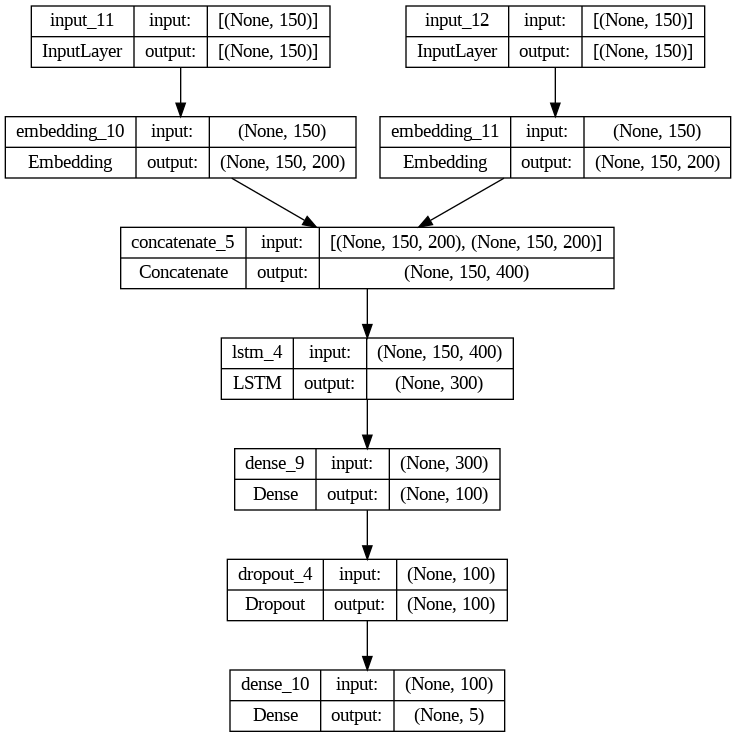

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
## --------- MAIN PROGRAM ----------- 
## --
## -- Usage:  train.py ../data/Train ../data/Devel  modelname
## --

# train model
with redirect_stdout(sys.stderr) :
   model.fit(Xt, Yt, batch_size=32, epochs=10, validation_data=(Xv,Yv), verbose=1)

# save model and indexs
model.save(modelname)
codes.save(modelname)
#save_model_and_indexs(model, idx, modelname)

# Predict 

In [ ]:
#import sys
import evaluator

In [ ]:
def output_interactions(data, preds, outfile) :

   #print(testdata[0])
   outf = open(outfile, 'w')
   for exmp,tag in zip(data.sentences(),preds) :
      sid = exmp['sid']
      e1 = exmp['e1']
      e2 = exmp['e2']
      if tag!='null' :
         print(sid, e1, e2, tag, sep="|", file=outf)

   outf.close()

In [ ]:
## --------- Evaluator ----------- 
def evaluation(datadir,outfile) :
   evaluator.evaluate("DDI", datadir, outfile)


In [ ]:
## --------- MAIN PROGRAM ----------- 
## --
## -- Usage:  baseline-NER.py target-dir
## --
## -- Extracts Drug NE from all XML files in target-dir
## --

X = codes.encode_words(valdata)
Y = model.predict(X)
Y = [codes.idx2label(np.argmax(s)) for s in Y]

# extract entities
output_interactions(valdata, Y, outfile)

# evaluate
evaluation(validationdir,outfile)
